# EV presence and consumption

Authors: Alessio Carnevale, Manuel Cattoni

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
df = pd.read_csv('data/ev_dataset.csv', delimiter=';')

This [dataset](https://data.4tu.nl/datasets/80ef3824-3f5d-4e45-8794-3b8791efbd13/1) collects 55,000 unique charging sessions from a large public parking lot in Utrecht.

In [3]:
print("Length of Dataset:", len(df))
df.info()

Length of Dataset: 55379
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55379 entries, 0 to 55378
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EV_id_x                    55379 non-null  object 
 1   start_datetime             55379 non-null  object 
 2   end_datetime               55379 non-null  object 
 3   total_energy               55379 non-null  float64
 4   rail                       55379 non-null  object 
 5   evse_uid                   55379 non-null  int64  
 6   channel                    55379 non-null  int64  
 7   capacity_kwh               3829 non-null   float64
 8   commute_km_range_min       4053 non-null   float64
 9   commute_km_range_max       4053 non-null   float64
 10  EV_brand_selfreported      4053 non-null   object 
 11  EV_model_selfreported      4053 non-null   object 
 12  capacity_kwh_selfreported  4053 non-null   object 
 13  ownership            

In [4]:
df.head()

,EV_id_x,start_datetime,end_datetime,total_energy,rail,evse_uid,channel,capacity_kwh,commute_km_range_min,commute_km_range_max,EV_brand_selfreported,EV_model_selfreported,capacity_kwh_selfreported,ownership
0,EV0,2020-08-25 11:56:02,2020-08-25 12:08:15,1.477,mennekes,600001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EV0,2020-08-25 12:20:30,2020-08-25 12:32:16,1.333,mennekes,600002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EV0,2020-08-25 12:40:47,2020-08-25 13:01:23,2.330,mennekes,600003,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EV0,2020-08-25 13:05:31,2020-08-25 13:37:29,3.764,mennekes,600005,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EV0,2020-08-25 14:03:28,2020-08-25 14:23:03,2.297,mennekes,600000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Convert start and end columns to datetime if not already
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df['end_datetime'] = pd.to_datetime(df['end_datetime'])

# Calculate duration in hours
df['duration'] = (df['end_datetime'] - df['start_datetime']).dt.total_seconds() / 3600

# Calculate average duration
avg_duration = df['duration'].mean()
print(f"Average charging duration: {avg_duration:.2f} hours")

Average charging duration: 6.55 hours


## Visualizations on Dataset

C:\Users\manuc\AppData\Local\Temp\ipykernel_27436\103576205.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_sessions.index, y=hourly_sessions.values,
C:\Users\manuc\AppData\Local\Temp\ipykernel_27436\103576205.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_brands.index, x=top_brands.values,


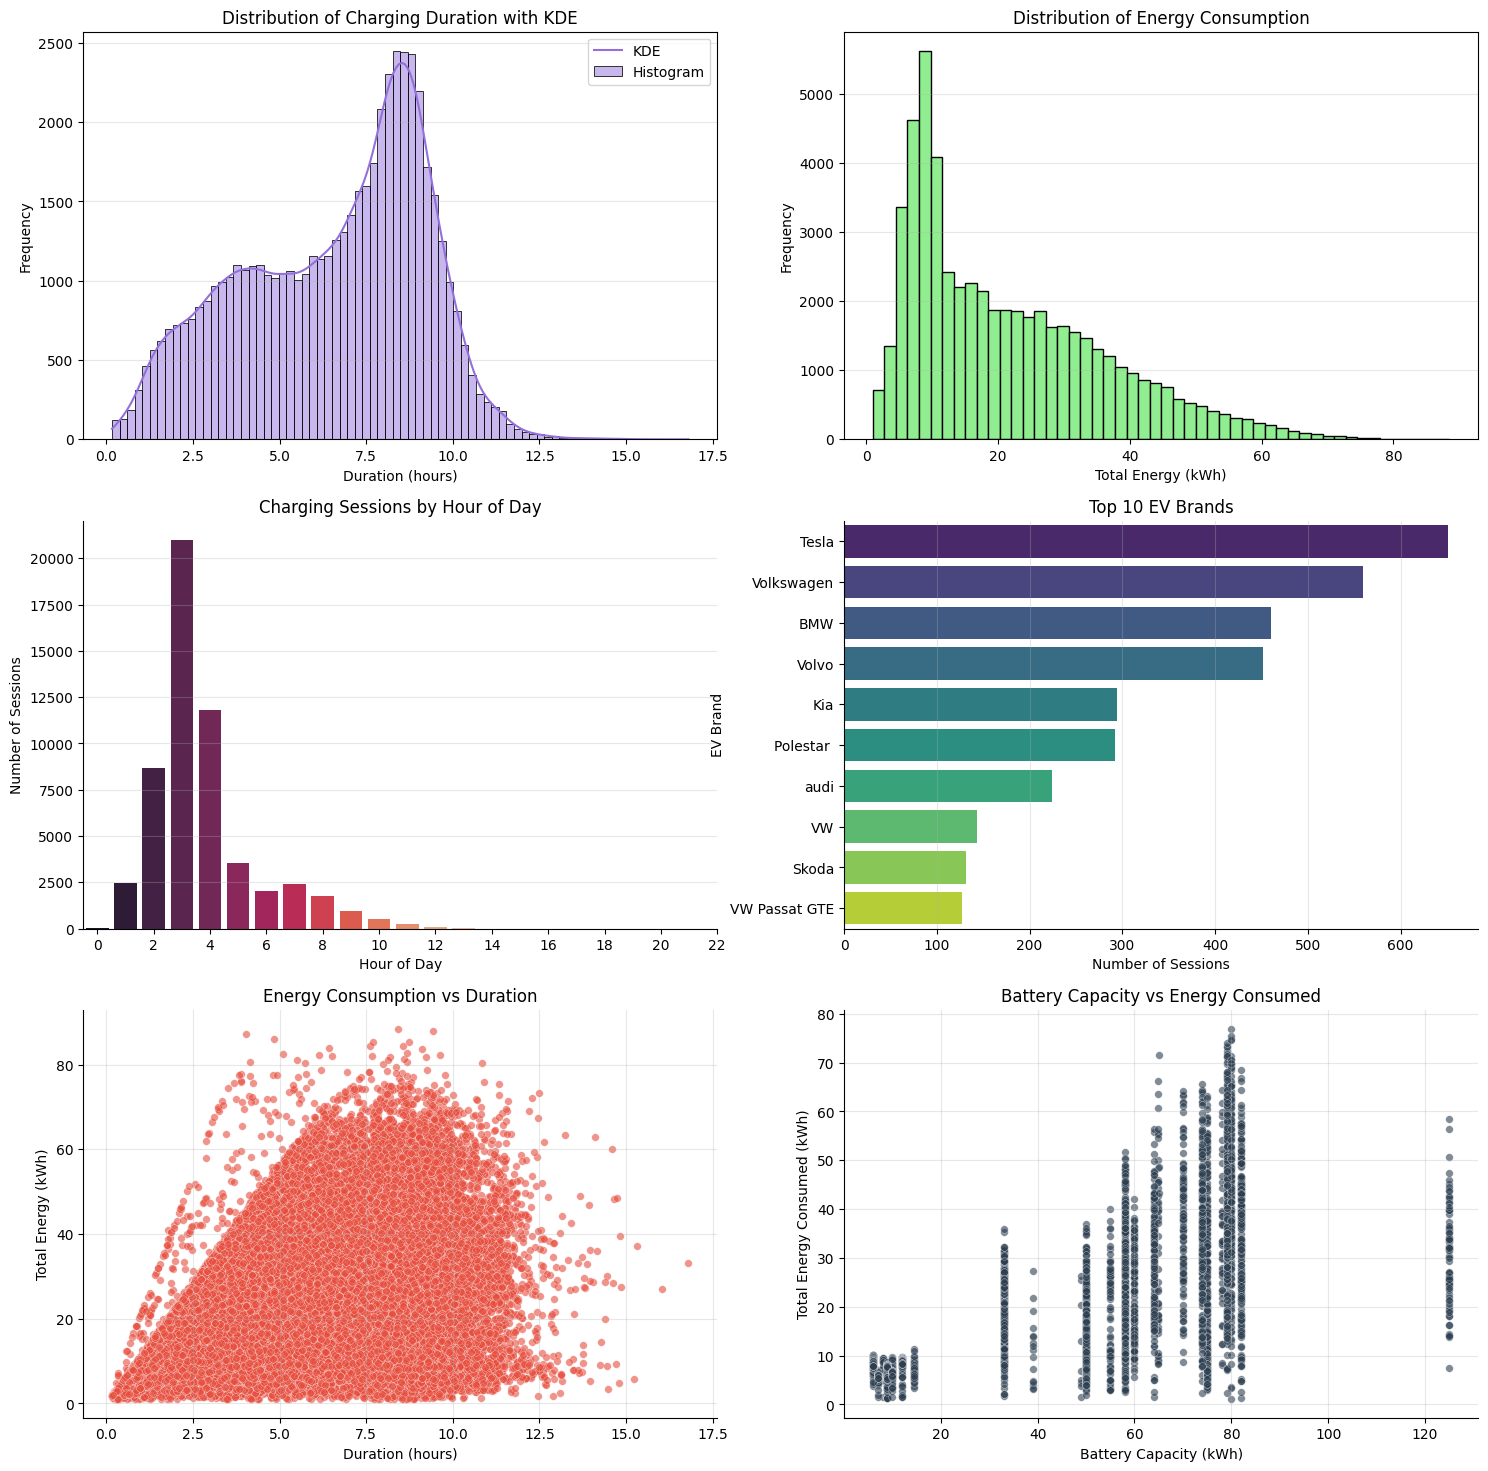

In [6]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# 1. Distribution plot of duration
sns.histplot(data=df, x='duration', kde=True, ax=axes[0, 0], color='mediumpurple', edgecolor='black')
axes[0, 0].set_title('Distribution of Charging Duration with KDE')
axes[0, 0].set_xlabel('Duration (hours)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].legend(['KDE', 'Histogram'])

# 2. Distribution of total energy consumed
axes[0, 1].hist(df['total_energy'], bins=50, edgecolor='black', color='lightgreen')
axes[0, 1].set_xlabel('Total Energy (kWh)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Energy Consumption')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Charging sessions by hour of day
df['start_hour'] = df['start_datetime'].dt.hour
hourly_sessions = df['start_hour'].value_counts().sort_index()

sns.barplot(x=hourly_sessions.index, y=hourly_sessions.values, 
            palette='rocket', ax=axes[1, 0], saturation=0.8)

axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Sessions')
axes[1, 0].set_title('Charging Sessions by Hour of Day')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].set_xticklabels(range(0, 24, 2))
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)

# 4. Top EV brands
top_brands = df['EV_brand_selfreported'].value_counts().head(10)

sns.barplot(y=top_brands.index, x=top_brands.values, 
            palette='viridis', ax=axes[1, 1], saturation=0.8)

axes[1, 1].set_xlabel('Number of Sessions')
axes[1, 1].set_ylabel('EV Brand')
axes[1, 1].set_title('Top 10 EV Brands')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)

# 5. Energy vs Duration scatter plot
sns.scatterplot(x='duration', y='total_energy', data=df, 
                alpha=0.6, s=30, color='#e74c3c', 
                edgecolor='white', linewidth=0.3, ax=axes[2, 0])

# Styling
axes[2, 0].set_xlabel('Duration (hours)')
axes[2, 0].set_ylabel('Total Energy (kWh)')
axes[2, 0].set_title('Energy Consumption vs Duration')
axes[2, 0].grid(alpha=0.3)
axes[2, 0].spines['top'].set_visible(False)
axes[2, 0].spines['right'].set_visible(False)

# 6. Capacity vs Total Energy scatter
sns.scatterplot(x='capacity_kwh', y='total_energy', data=df, 
                alpha=0.6, s=30, color='#2c3e50', 
                edgecolor='white', linewidth=0.3, ax=axes[2, 1])

# Styling
axes[2, 1].set_xlabel('Battery Capacity (kWh)')
axes[2, 1].set_ylabel('Total Energy Consumed (kWh)')
axes[2, 1].set_title('Battery Capacity vs Energy Consumed')
axes[2, 1].grid(alpha=0.3)
axes[2, 1].spines['top'].set_visible(False)
axes[2, 1].spines['right'].set_visible(False)

## Correlation Matrix

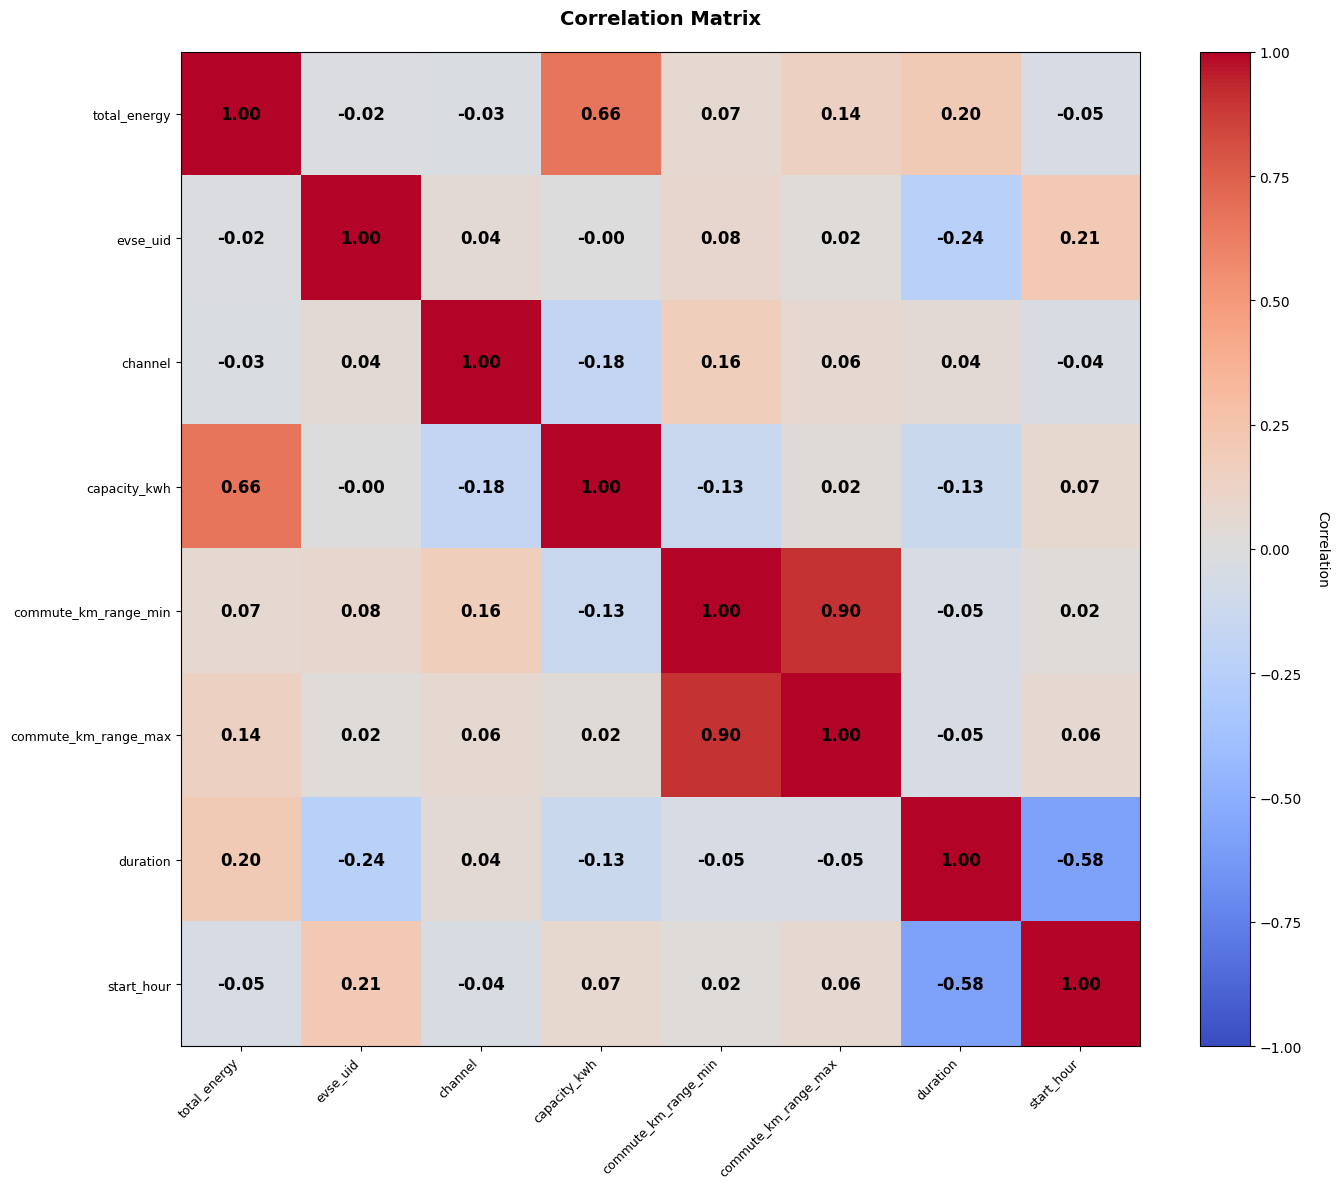

In [7]:

# Calculate correlation matrix for numeric columns
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Create the heatmap using imshow
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# Set ticks and labels
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(correlation_matrix.columns, fontsize=9)

# Add text annotations for all values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=12, weight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', rotation=270, labelpad=20)

ax.set_title('Correlation Matrix', fontsize=14, pad=20, weight='bold')
plt.tight_layout()
plt.show()

## ACF Plot

<Figure size 1000x400 with 0 Axes>

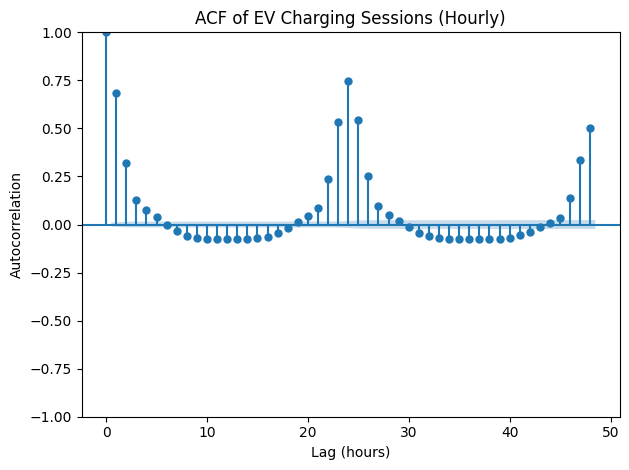

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

ts = (
    df
    .set_index('start_datetime')
    .resample('h')
    .size()
)

plt.figure(figsize=(10, 4))
plot_acf(ts, lags=48)
plt.title("ACF of EV Charging Sessions (Hourly)")
plt.xlabel("Lag (hours)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


# Dataset transformation

In [9]:
import pandas as pd
import numpy as np

# 1. Assicurati che le date siano datetime
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df['end_datetime'] = pd.to_datetime(df['end_datetime'])

def create_time_series(df, group_col=None):
    rows = []
    for _, row in df.iterrows():
        # Genera il range orario tra inizio e fine sessione
        # Usiamo 'h' invece di 'H' per evitare il FutureWarning
        hours = pd.date_range(
            start=row['start_datetime'].replace(minute=0, second=0, microsecond=0),
            end=row['end_datetime'],
            freq='h' 
        )
        
        # Calcolo energia media oraria (distribuzione lineare)
        duration = (row['end_datetime'] - row['start_datetime']).total_seconds() / 3600
        energy_per_hour = row['total_energy'] / duration if duration > 0 else 0
        
        for h in hours:
            data = {
                'timestamp': h,
                'presence': 1,
                'consumption': energy_per_hour
            }
            # IMPORTANTE: Aggiungiamo la colonna rail se richiesta
            if group_col and group_col in row:
                data[group_col] = row[group_col]
            rows.append(data)
            
    return pd.DataFrame(rows)

# --- ESECUZIONE ---

# Specifichiamo 'rail' così la colonna verrà inclusa nel nuovo dataframe
df_expanded = create_time_series(df, group_col='rail')

# 1. Serie Temporale Totale (Fleet)
fleet_ts = df_expanded.groupby('timestamp').agg({
    'presence': 'sum',
    'consumption': 'sum'
}).resample('h').sum().fillna(0)

# 2. Serie Temporale per Location (Rail)
# Ora 'rail' esiste in df_expanded, quindi non darà KeyError
rail_ts = df_expanded.groupby(['timestamp', 'rail']).agg({
    'presence': 'sum',
    'consumption': 'sum'
}).unstack(fill_value=0)

print("Check Fleet Time Series:")
print(fleet_ts.head())

print("\nCheck Rail Time Series (Presence per ogni rail):")
print(rail_ts['presence'].head())

Check Fleet Time Series:
                     presence  consumption
timestamp                                 
2020-08-25 11:00:00         1     7.254025
2020-08-25 12:00:00         3    20.837599
2020-08-25 13:00:00         2    13.851267
2020-08-25 14:00:00         2    23.745309
2020-08-25 15:00:00         0     0.000000

Check Rail Time Series (Presence per ogni rail):
rail                 B  C  E  H  J  K  L  M  carport groot  carport klein  \
timestamp                                                                   
2020-08-25 11:00:00  0  0  0  0  0  0  0  0              0              0   
2020-08-25 12:00:00  0  0  0  0  0  0  0  0              0              0   
2020-08-25 13:00:00  0  0  0  0  0  0  0  0              0              0   
2020-08-25 14:00:00  0  0  0  0  0  0  0  0              0              0   
2020-08-27 08:00:00  0  0  0  0  0  0  0  0              0              0   

rail                 mennekes  shared car  visitors  \
timestamp                    

In [10]:
def prepare_features(df_ts):
    df = df_ts.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Lag features: il valore dell'ora precedente o del giorno precedente
    df['consumption_lag_24'] = df['consumption'].shift(24) # Consumo stessa ora ieri
    df['presence_lag_24'] = df['presence'].shift(24)
    
    return df.dropna()

fleet_features = prepare_features(fleet_ts)

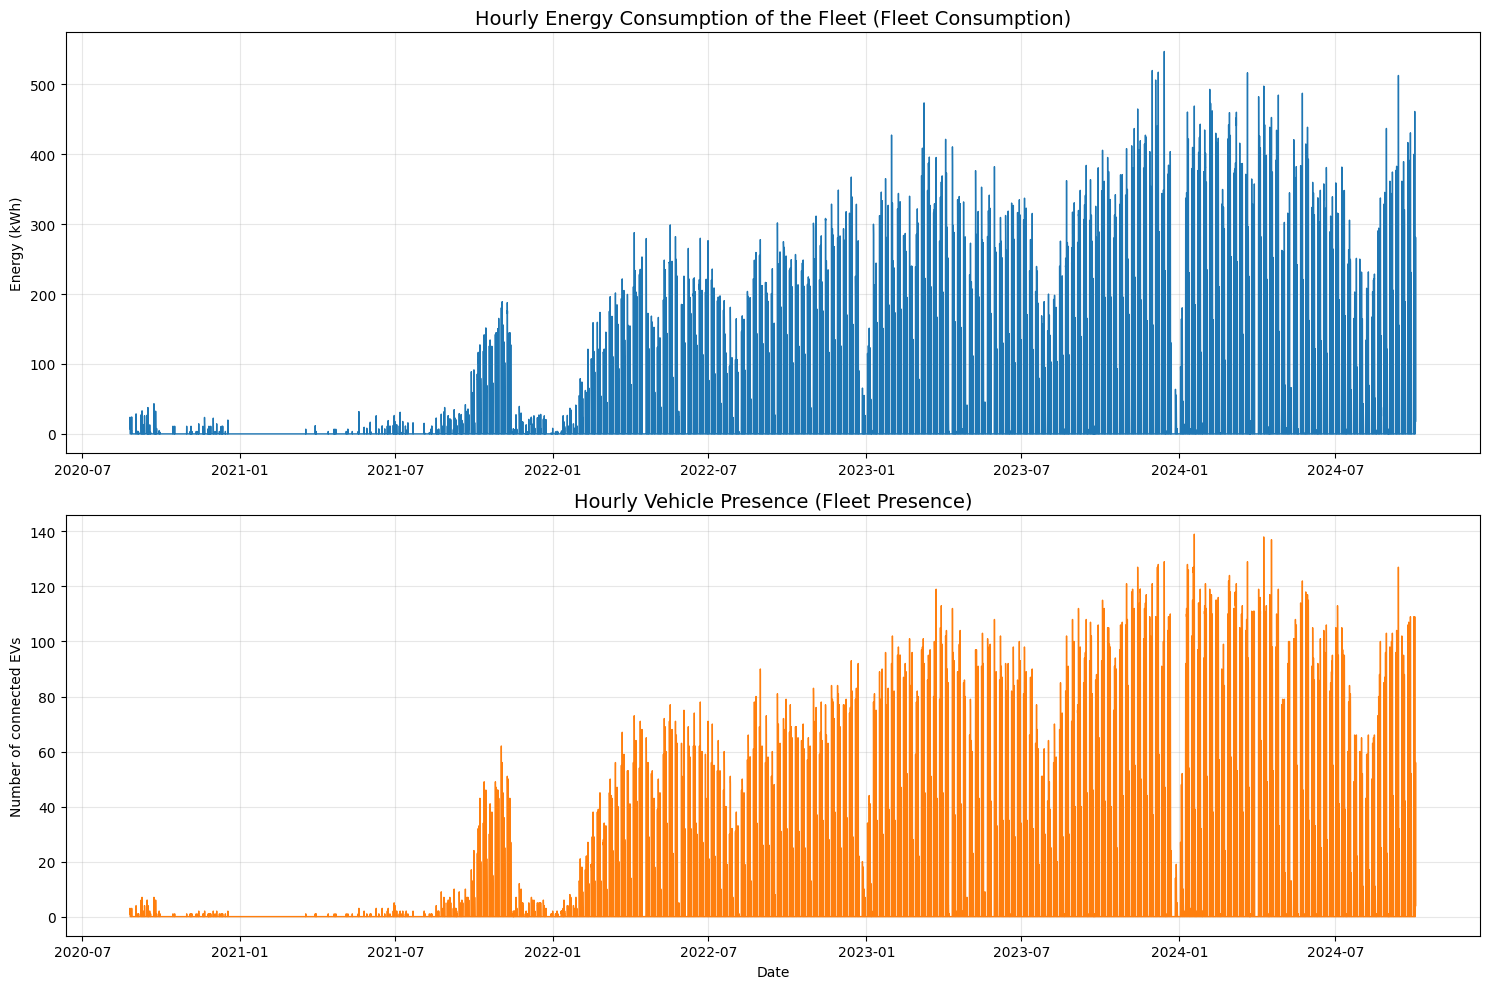

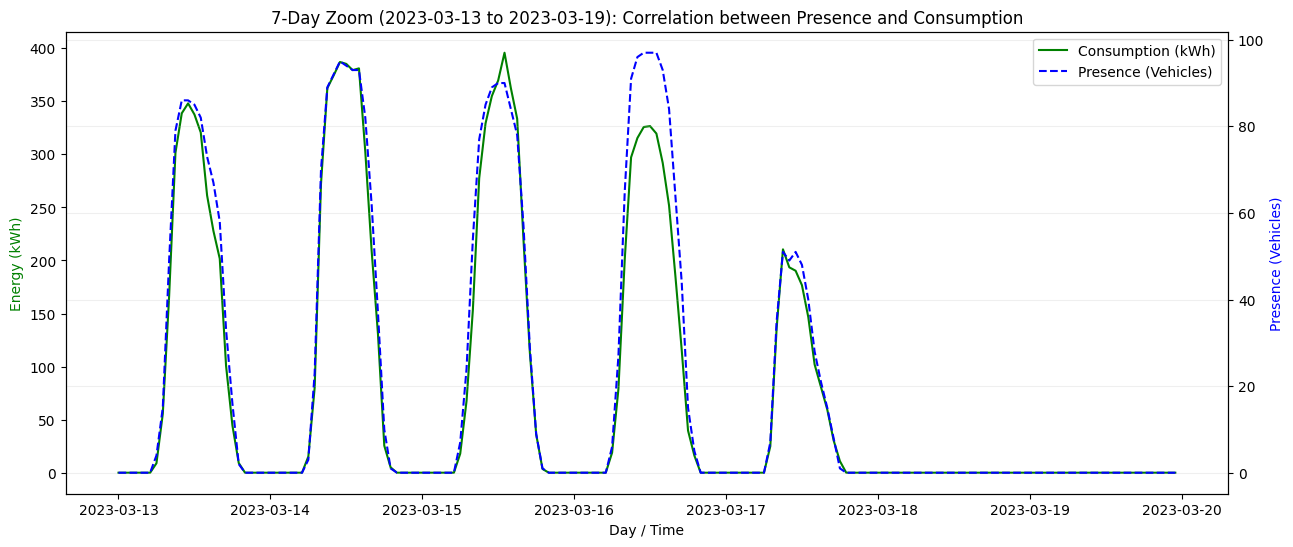

In [11]:
# Set visual style
plt.figure(figsize=(15, 10))

# --- GRAPH 1: Total Fleet Energy Consumption (kWh) ---
plt.subplot(2, 1, 1)
plt.plot(fleet_ts.index, fleet_ts['consumption'], color='tab:blue', linewidth=1)
plt.title('Hourly Energy Consumption of the Fleet (Fleet Consumption)', fontsize=14)
plt.ylabel('Energy (kWh)')
plt.grid(True, alpha=0.3)

# --- GRAPH 2: Vehicle Presence (Presence) ---
plt.subplot(2, 1, 2)
plt.plot(fleet_ts.index, fleet_ts['presence'], color='tab:orange', linewidth=1)
plt.title('Hourly Vehicle Presence (Fleet Presence)', fontsize=14)
plt.ylabel('Number of connected EVs')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- ZOOM: Representative week in March 2023 ---
# Selecting a standard week: Monday, March 13th to Sunday, March 19th, 2023
start_date = '2023-03-13'
end_date = '2023-03-19'
sample_week = fleet_ts.loc[start_date:end_date]

fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
# Plotting Consumption on the primary Y-axis (left)
ax1.plot(sample_week.index, sample_week['consumption'], 'g-', label='Consumption (kWh)')
# Plotting Presence on the secondary Y-axis (right)
ax2.plot(sample_week.index, sample_week['presence'], 'b--', label='Presence (Vehicles)')

ax1.set_xlabel('Day / Time')
ax1.set_ylabel('Energy (kWh)', color='g')
ax2.set_ylabel('Presence (Vehicles)', color='b')
plt.title(f'7-Day Zoom ({start_date} to {end_date}): Correlation between Presence and Consumption')
plt.grid(True, alpha=0.2)

# Combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

## Stationary test

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

def check_stationarity(series, name):
    print(f"--- Stationarity Tests for: {name} ---")
    
    # 1. ADF Test (H0: La serie ha una radice unitaria / Non è stazionaria)
    adf_result = adfuller(series.dropna())
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'ADF p-value: {adf_result[1]:.4f}')
    
    # 2. KPSS Test (H0: La serie è stazionaria)
    # L'opzione regression='ct' considera la stazionarietà attorno a un trend
    kpss_result = kpss(series.dropna(), regression='ct')
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'KPSS p-value: {kpss_result[1]:.4f}')
    
    # Interpretazione rapida
    is_stationary = (adf_result[1] < 0.05) and (kpss_result[1] > 0.05)
    print(f"Conclusion: {'Stationary' if is_stationary else 'Non-Stationary'}")
    print("-" * 40)

# Esecuzione sui dati della flotta
check_stationarity(fleet_ts['consumption'], "Fleet Consumption")
check_stationarity(fleet_ts['presence'], "Fleet Presence")

--- Stationarity Tests for: Fleet Consumption ---
ADF Statistic: -20.1030
ADF p-value: 0.0000
KPSS Statistic: 0.6189
KPSS p-value: 0.0100
Conclusion: Non-Stationary
----------------------------------------
--- Stationarity Tests for: Fleet Presence ---


C:\Users\manuc\AppData\Local\Temp\ipykernel_27436\2655511452.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='ct')


ADF Statistic: -20.9058
ADF p-value: 0.0000
KPSS Statistic: 0.6685
KPSS p-value: 0.0100
Conclusion: Non-Stationary
----------------------------------------


C:\Users\manuc\AppData\Local\Temp\ipykernel_27436\2655511452.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='ct')


## Simple models

In [13]:
# def cast_df(y, df):
#     h = len(y)
#     return pd.DataFrame(
#         y,
#         index=pd.date_range(
#             start=df.index[-1] + pd.Timedelta(hours=1),
#             periods=h,
#             freq='h'
#         )
#     )

# def naive(x, h):
#     return cast_df(np.repeat(x.iloc[-1], h), x)

# def mean_forecast(x, h):
#     return cast_df(np.repeat(x.mean(), h), x)

# def seasonal_naive(x, h, m=24):
#     values = x.iloc[-m:].values
#     y_hat = np.tile(values, int(np.ceil(h / m)))[:h]
#     return cast_df(y_hat, x)

# def calculate_nmae(y_true, y_pred, y_train_mean):
#     mae_model = np.mean(np.abs(y_true - y_pred))
#     mae_mean_baseline = np.mean(np.abs(y_true - y_train_mean))
#     return mae_model / mae_mean_baseline

# def evaluate_models(ts, split_date, h=24, m=24, name="Series", plot_residuals=True):
#     # Split
#     train = ts.loc[:split_date]
#     test = ts.loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h]

#     y_true = test.values
#     train_mean = train.mean()

#     # Forecast
#     forecasts = {
#         'Naive': naive(train, h),
#         'Mean': mean_forecast(train, h),
#         'Seasonal Naive': seasonal_naive(train, h, m)
#     }

#     # Metriche
#     print(f"\nnMAE Results | {name}")
#     for model, f in forecasts.items():
#         score = calculate_nmae(y_true, f.values.ravel(), train_mean)
#         print(f"{model}: {score:.4f}")

#     # Residual analysis SOLO per Seasonal Naive
#     residuals = y_true - forecasts['Seasonal Naive'].values.ravel()

#     if plot_residuals:
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

#         # Residui
#         ax1.plot(test.index, residuals, color='red')
#         ax1.axhline(0, color='black', linestyle='--')
#         ax1.set_title(f'Residuals – Seasonal Naive ({name})')

#         # ACF
#         plot_acf(residuals, lags=12, zero=False, ax=ax2)
#         ax2.set_title('ACF of Residuals')

#         plt.tight_layout()
#         plt.show()

#         # Ljung-Box
#         lb = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
#         p_val = lb['lb_pvalue'].iloc[0]

#         print("\nLjung-Box Test")
#         print(lb)

#         if p_val > 0.05:
#             print("Residuals are White Noise → model captured main structure.")
#         else:
#             print("Residuals NOT White Noise → more complex model needed.")
#         print("-"*80)
#         print("-"*80)


# split_date = '2023-03-15 23:00:00'

# for rail in rail_ts['consumption'].columns:
#     evaluate_models(
#         ts=rail_ts['consumption'][rail],
#         split_date=split_date,
#         name=f"Rail {rail} – Consumption"
#     )

nMAE Comparative Table per Rail (Benchmarks):
               Naive  Mean   S_Naive
K           0.000000   1.0  0.000000
J           1.241012   1.0  0.945024
shared car  1.003669   1.0  1.025737
visitors    1.009990   1.0  1.103839
B           1.499682   1.0  1.240661
mennekes    1.631182   1.0  1.433443
H           1.732555   1.0  1.607852
E           1.879032   1.0  1.820885
C           1.337543   1.0  1.978001
M           1.173333   1.0  2.152573


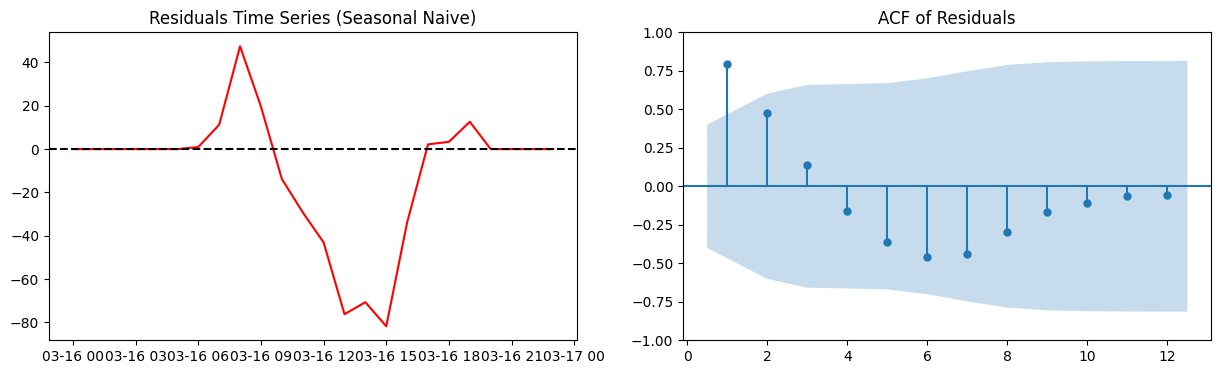

Ljung-Box Portmanteau Test (lag=10):
p-value: 0.000000
Conclusion: Residuals are NOT White Noise. more complex model required


In [ ]:
# # import numpy as np
# # import pandas as pd
# # import statsmodels.api as sm
# # from statsmodels.graphics.tsaplots import plot_acf
# # import matplotlib.pyplot as plt

# # --- 1. CORE FUNCTIONS (Simple Models & Metrics) ---

# def cast_df(y, df):
#     """Aligns the forecast index to follow the training data chronologically."""
#     h = len(y)
#     return pd.DataFrame(y, index=pd.date_range(
#         start=df.index[-1] + pd.Timedelta(hours=1), 
#         periods=h, 
#         freq='h'
#     ))

# def naive(x, h): 
#     """Persistent forecast: future values equal the last observed value."""
#     return cast_df(np.repeat(x.iloc[-1], h), x)

# def mean_fc(x, h): 
#     """Forecast based on the historical mean of the entire series."""
#     return cast_df(np.repeat(x.mean(), h), x)

# def seasonal_naive(x, h, m=24):
#     """Seasonal forecast: repeats the last cycle of m hours (24h for EV data)."""
#     values = x.iloc[-m:].values
#     y_hat = np.tile(values, int(np.ceil(h/m)))[:h]
#     return cast_df(y_hat, x)

# def calculate_nmae(y_true, y_pred, y_train_mean):
#     """
#     Calculates Normalized Mean Absolute Error (nMAE) as defined in L02.
#     Includes a safeguard against division by zero for inactive charging points.
#     """
#     mae = np.mean(np.abs(y_true - y_pred))
#     mae_baseline = np.mean(np.abs(y_true - y_train_mean))
#     return mae / mae_baseline if mae_baseline != 0 else np.nan

# # --- 2. MULTI-SERIES BENCHMARKING (Location-based / Rail) ---

# def get_benchmark_scores(ts, split_date, h=24):
#     """Calculates nMAE scores for simple models on a specific time series."""
#     train = ts.loc[:split_date]
#     test = ts.loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h]
    
#     # Ensure there is enough data for the test horizon
#     if len(test) < h: return None
    
#     y_true, y_train_mean = test.values.ravel(), train.mean()

#     return {
#         'Naive': calculate_nmae(y_true, naive(train, h).values.ravel(), y_train_mean),
#         'Mean': calculate_nmae(y_true, mean_fc(train, h).values.ravel(), y_train_mean),
#         'S_Naive': calculate_nmae(y_true, seasonal_naive(train, h).values.ravel(), y_train_mean)
#     }

# # Execute benchmarking for each rail and display a summary table
# split_date = '2023-03-15 23:00:00'
# benchmark_results = {rail: get_benchmark_scores(rail_ts['consumption'][rail], split_date) 
#                     for rail in rail_ts['consumption'].columns}

# df_benchmarks = pd.DataFrame(benchmark_results).T.dropna().sort_values('S_Naive')
# print("nMAE Comparative Table per Rail (Benchmarks):")
# print(df_benchmarks)

# # --- 3. RESIDUAL DIAGNOSTICS (Overall Fleet) ---

# def analyze_residuals(ts, split_date, h=24):
#     """
#     Analyzes residuals of the best simple model (Seasonal Naive) to check for 
#     White Noise using ACF and Ljung-Box tests.
#     """
#     train = ts.loc[:split_date]
#     test = ts.loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h]
#     y_true = test.values.ravel()
    
#     # Generate forecast using the best benchmark
#     fc = seasonal_naive(train, h).values.ravel()
#     residuals = y_true - fc

#     # Visualization
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    
#     # Residuals time series
#     ax1.plot(test.index, residuals, color='red', label='Residuals')
#     ax1.axhline(0, color='black', ls='--')
#     ax1.set_title("Residuals Time Series (Seasonal Naive)")
    
#     # Autocorrelation Function (ACF) of residuals
#     plot_acf(residuals, lags=12, zero=False, ax=ax2)
#     ax2.set_title("ACF of Residuals")
#     plt.show()

#     # Formal Portmanteau Test (Ljung-Box)
#     lb = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
#     p_val = lb['lb_pvalue'].iloc[0]
    
#     print(f"Ljung-Box Portmanteau Test (lag=10):")
#     print(f"p-value: {p_val:.6f}")
    
#     if p_val < 0.05:
#         print("Conclusion: Residuals are NOT White Noise. more complex model required")
#     else:
#         print("Conclusion: Residuals are White Noise. The simple model captured the main structure")

# # Execute residual analysis for the overall fleet consumption
# analyze_residuals(fleet_ts['consumption'], split_date)

OVERALL FLEET - Benchmark nMAE Scores
Naive      1.02584
Mean       1.00000
S_Naive    0.16422
dtype: float64

PER-LOCATION Benchmark nMAE Scores (sorted by S_Naive)
               Naive  Mean   S_Naive
K           0.000000   1.0  0.000000
J           1.241012   1.0  0.945024
shared car  1.003669   1.0  1.025737
visitors    1.009990   1.0  1.103839
B           1.499682   1.0  1.240661
mennekes    1.631182   1.0  1.433443
H           1.732555   1.0  1.607852
E           1.879032   1.0  1.820885
C           1.337543   1.0  1.978001
M           1.173333   1.0  2.152573

OVERALL FLEET - 24h Forecast Comparison
                         Actual  Naive       Mean     S_Naive
timestamp                                                    
2023-03-16 00:00:00    0.000000    0.0  22.015639    0.000000
2023-03-16 01:00:00    0.000000    0.0  22.015639    0.000000
2023-03-16 02:00:00    0.000000    0.0  22.015639    0.000000
2023-03-16 03:00:00    0.000000    0.0  22.015639    0.000000
2023-03-16 04:

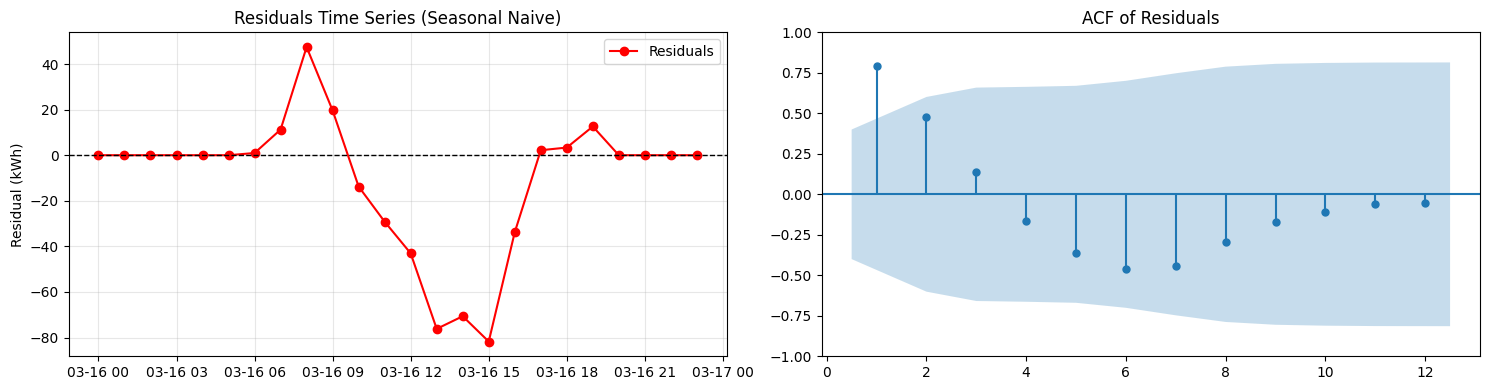

RESIDUAL DIAGNOSTICS - Overall Fleet
Ljung-Box Test (lag=10):
  p-value: 0.000000
  Mean residual: -10.4544
  Std residual: 30.1566

  ⚠ Conclusion: Residuals are NOT White Noise (p=0.0000)
    → Seasonal Naive captures main structure but some autocorrelation remains
    → Consider ARIMA/ExponentialSmoothing for better fit

SUMMARY - Naive Benchmark Phase
Total locations benchmarked: 10
Overall fleet: ✓
Training period: start → 2023-03-15 23:00:00
Test period: 24h from 2023-03-16 00:00:00

Best model by fleet:  S_Naive
Best model by median (locations):  K


In [ ]:
# ============================================================================
# 1. CORE FUNCTIONS (Simple Models & Metrics)
# ============================================================================

def cast_df(y, df):
    """Aligns the forecast index to follow the training data chronologically."""
    h = len(y)
    return pd.DataFrame(y, index=pd.date_range(
        start=df.index[-1] + pd.Timedelta(hours=1), 
        periods=h, 
        freq='h'
    ))


def naive(x, h): 
    """Persistent forecast: future values equal the last observed value."""
    return cast_df(np.repeat(x.iloc[-1], h), x)


def mean_fc(x, h): 
    """Forecast based on the historical mean of the entire series."""
    return cast_df(np.repeat(x.mean(), h), x)


def seasonal_naive(x, h, m=24):
    """Seasonal forecast: repeats the last cycle of m hours (24h for EV data)."""
    values = x.iloc[-m:].values
    y_hat = np.tile(values, int(np.ceil(h/m)))[:h]
    return cast_df(y_hat, x)


def calculate_nmae(y_true, y_pred, y_train_mean):
    """
    Calculates Normalized Mean Absolute Error (nMAE).
    Safeguard against division by zero for inactive charging points.
    """
    mae = np.mean(np.abs(y_true - y_pred))
    mae_baseline = np.mean(np.abs(y_true - y_train_mean))
    return mae / mae_baseline if mae_baseline != 0 else np.nan


# ============================================================================
# 2. BENCHMARKING: OVERALL FLEET
# ============================================================================

def get_benchmark_scores_fleet(ts, split_date, h=24):
    """
    Calculates nMAE scores for simple models on the overall fleet time series.
    Returns dict with model names and their scores.
    """
    train = ts.loc[:split_date]
    test = ts.loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h]
    
    if len(test) < h:
        return None
    
    y_true = test.values.ravel()
    y_train_mean = train.mean()

    return {
        'Naive': calculate_nmae(y_true, naive(train, h).values.ravel(), y_train_mean),
        'Mean': calculate_nmae(y_true, mean_fc(train, h).values.ravel(), y_train_mean),
        'S_Naive': calculate_nmae(y_true, seasonal_naive(train, h).values.ravel(), y_train_mean)
    }


# Execute benchmarking for overall fleet
split_date = '2023-03-15 23:00:00'
scores_fleet = get_benchmark_scores_fleet(fleet_ts['consumption'], split_date)

print("=" * 60)
print("OVERALL FLEET - Benchmark nMAE Scores")
print("=" * 60)
print(pd.Series(scores_fleet))
print()


# ============================================================================
# 3. BENCHMARKING: PER LOCATION (Rail)
# ============================================================================

def get_benchmark_scores_location(ts, split_date, h=24):
    """
    Calculates nMAE scores for simple models on a specific location time series.
    """
    train = ts.loc[:split_date]
    test = ts.loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h]
    
    if len(test) < h:
        return None
    
    y_true = test.values.ravel()
    y_train_mean = train.mean()

    return {
        'Naive': calculate_nmae(y_true, naive(train, h).values.ravel(), y_train_mean),
        'Mean': calculate_nmae(y_true, mean_fc(train, h).values.ravel(), y_train_mean),
        'S_Naive': calculate_nmae(y_true, seasonal_naive(train, h).values.ravel(), y_train_mean)
    }


# Execute benchmarking for each rail/location
benchmark_results = {
    rail: get_benchmark_scores_location(rail_ts['consumption'][rail], split_date) 
    for rail in rail_ts['consumption'].columns
}

df_benchmarks = pd.DataFrame(benchmark_results).T.dropna().sort_values('S_Naive')

print("=" * 60)
print("PER-LOCATION Benchmark nMAE Scores (sorted by S_Naive)")
print("=" * 60)
print(df_benchmarks)
print()


# ============================================================================
# 4. GENERATE FORECASTS: OVERALL FLEET (24h ahead)
# ============================================================================

train_fleet = fleet_ts['consumption'].loc[:split_date]
test_fleet = fleet_ts['consumption'].loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:24]

fc_naive_fleet = naive(train_fleet, 24)
fc_mean_fleet = mean_fc(train_fleet, 24)
fc_seasonal_fleet = seasonal_naive(train_fleet, 24)

# Create comparison DataFrame
fleet_forecasts = pd.DataFrame({
    'Actual': test_fleet.values.ravel(),
    'Naive': fc_naive_fleet.values.ravel(),
    'Mean': fc_mean_fleet.values.ravel(),
    'S_Naive': fc_seasonal_fleet.values.ravel()
}, index=test_fleet.index)

print("=" * 60)
print("OVERALL FLEET - 24h Forecast Comparison")
print("=" * 60)
print(fleet_forecasts.head(12))
print("...")
print(fleet_forecasts.tail(12))
print()


# ============================================================================
# 5. GENERATE FORECASTS: PER LOCATION (24h ahead) - Best Model
# ============================================================================

# For each location, use its best model (S_Naive in most cases)
location_forecasts = {}

for rail in rail_ts['consumption'].columns:
    train_loc = rail_ts['consumption'][rail].loc[:split_date]
    test_loc = rail_ts['consumption'][rail].loc[
        pd.to_datetime(split_date) + pd.Timedelta(hours=1):
    ].iloc[:24]
    
    if len(test_loc) < 24:
        continue
    
    # Use S_Naive as best model
    fc = seasonal_naive(train_loc, 24).values.ravel()
    
    location_forecasts[rail] = pd.DataFrame({
        'Actual': test_loc.values.ravel(),
        'S_Naive': fc
    }, index=test_loc.index)

print("=" * 60)
print("PER-LOCATION - 24h Forecast (S_Naive, sample locations)")
print("=" * 60)
# Display first 3 locations
for i, (rail, fc_df) in enumerate(list(location_forecasts.items())[:3]):
    print(f"\nRail: {rail}")
    print(fc_df.head(8))
print()


# ============================================================================
# 6. RESIDUAL DIAGNOSTICS: OVERALL FLEET
# ============================================================================

def analyze_residuals(ts, split_date, h=24, model_func=seasonal_naive):
    """
    Analyzes residuals of a forecasting model using ACF and Ljung-Box test.
    """
    train = ts.loc[:split_date]
    test = ts.loc[pd.to_datetime(split_date) + pd.Timedelta(hours=1):].iloc[:h]
    y_true = test.values.ravel()
    
    # Generate forecast
    fc = model_func(train, h).values.ravel()
    residuals = y_true - fc

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    
    # Residuals time series
    ax1.plot(test.index, residuals, color='red', marker='o', label='Residuals')
    ax1.axhline(0, color='black', ls='--', linewidth=1)
    ax1.set_title("Residuals Time Series (Seasonal Naive)")
    ax1.set_ylabel("Residual (kWh)")
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Autocorrelation Function (ACF) of residuals
    plot_acf(residuals, lags=12, zero=False, ax=ax2)
    ax2.set_title("ACF of Residuals")
    plt.tight_layout()
    plt.show()

    # Formal Portmanteau Test (Ljung-Box)
    lb = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    p_val = lb['lb_pvalue'].iloc[0]
    
    print("=" * 60)
    print("RESIDUAL DIAGNOSTICS - Overall Fleet")
    print("=" * 60)
    print(f"Ljung-Box Test (lag=10):")
    print(f"  p-value: {p_val:.6f}")
    print(f"  Mean residual: {residuals.mean():.4f}")
    print(f"  Std residual: {residuals.std():.4f}")
    
    if p_val < 0.05:
        print(f"\n  ⚠ Conclusion: Residuals are NOT White Noise (p={p_val:.4f})")
        print(f"    → Seasonal Naive captures main structure but some autocorrelation remains")
        print(f"    → Consider ARIMA/ExponentialSmoothing for better fit")
    else:
        print(f"\n  ✓ Conclusion: Residuals are White Noise (p={p_val:.4f})")
        print(f"    → Seasonal Naive has captured the main temporal structure")
    print()


# Execute residual analysis
analyze_residuals(fleet_ts['consumption'], split_date, h=24, model_func=seasonal_naive)


# ============================================================================
# 7. SUMMARY STATISTICS
# ============================================================================

print("=" * 60)
print("SUMMARY - Naive Benchmark Phase")
print("=" * 60)
print(f"Total locations benchmarked: {len(df_benchmarks)}")
print(f"Overall fleet: ✓")
print(f"Training period: start → {split_date}")
print(f"Test period: 24h from {pd.to_datetime(split_date) + pd.Timedelta(hours=1)}")
print()

model_names = list(scores_fleet.keys())
model_values = list(scores_fleet.values())
best_model_idx = np.argmin(model_values)

print("Best model by fleet: ", model_names[best_model_idx])
print("Best model by median (locations): ", df_benchmarks['S_Naive'].idxmin())